# Method :  Synthetic signal analysis (slow and fast components)

In [1]:
import numpy as np
from scipy.signal import hilbert
import xarray as xr
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

import sstats.tseries as ts

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:55210 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## Generating data + plot raw data and autocorrelation

In [3]:
Tw = 500
Nw = 50
Tl = 10

### Generating fast component : modulated fast oscillations

In [4]:
xtilde = ts.exp_autocorr((Tw, 1./24), np.full((Nw,),Tl).tolist(), 1, draws=100, name='xtilde').rename({'tau':'windows'})#.persist()
ytilde = ts.exp_autocorr((Tw, 1./24), np.full((Nw,),Tl).tolist(), 1, draws=100, name='ytilde').rename({'tau':'windows'})#.persist()
omega = 2*np.pi*2

ztilde = np.real((0.+xtilde)*np.cos(omega*xtilde.time)+1j*ytilde*np.sin(omega*xtilde.time)).rename('ztilde')#.persist()

#zhtilde = xr.apply_ufunc(hilbert, ztilde, dask='parallelized', output_dtypes=[complex])

#Rtilde = np.abs(zhtilde)
#thetatilde = np.angle(zhtilde)

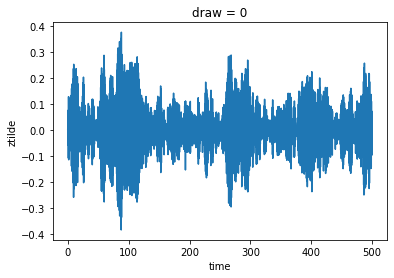

In [4]:
ztilde.sel(draw=0).mean('windows').plot()

In [5]:
xx = ts.correlate(ztilde,ztilde,detrend=False).persist()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Zoom mean : lags$\\in$[50;250]')

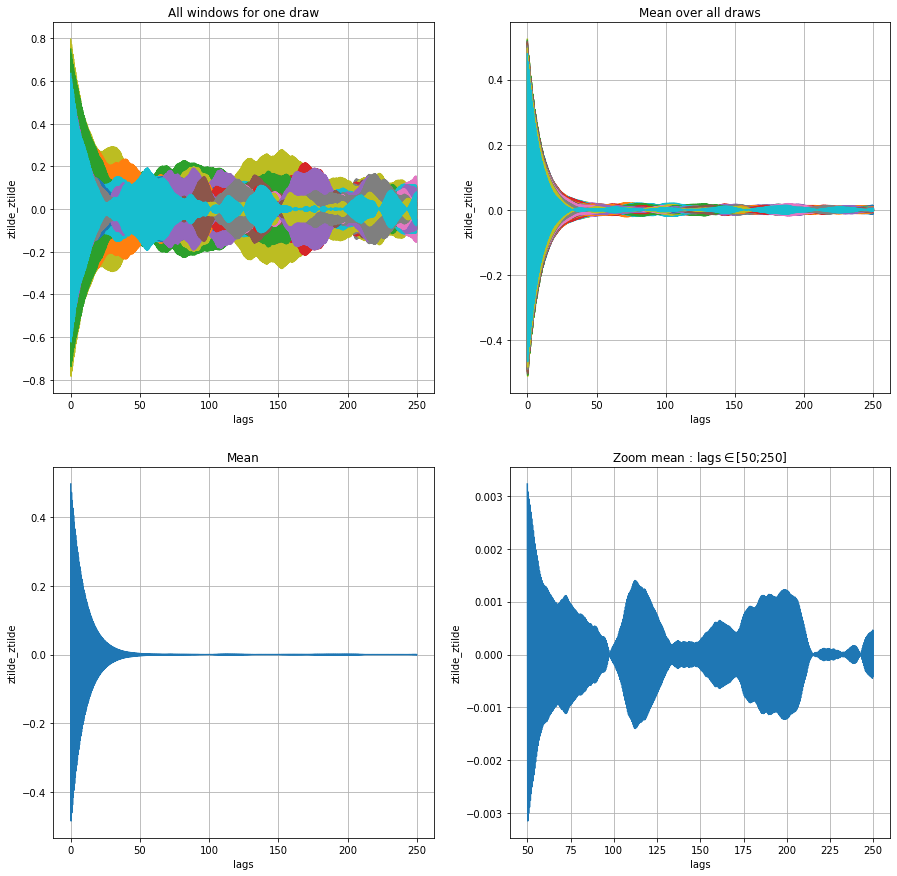

In [25]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xx.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xx.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xx.mean(['draw','windows']).plot(ax=ax[1,0])
xx.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid();ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

### Generating slow component : exponentially correlated time series

In [10]:
xbar = ts.exp_autocorr((Tw, 1./24), np.full((Nw,),Tl).tolist(), 1, draws=100, name='xbar').rename({'tau':'windows'})#.persist()

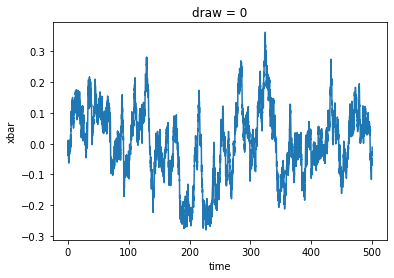

In [11]:
xbar.sel(draw=0).mean('windows').plot()

In [12]:
xxbar = ts.correlate(xbar,xbar,detrend=False).persist()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Zoom mean : lags$\\in$[50;250]')

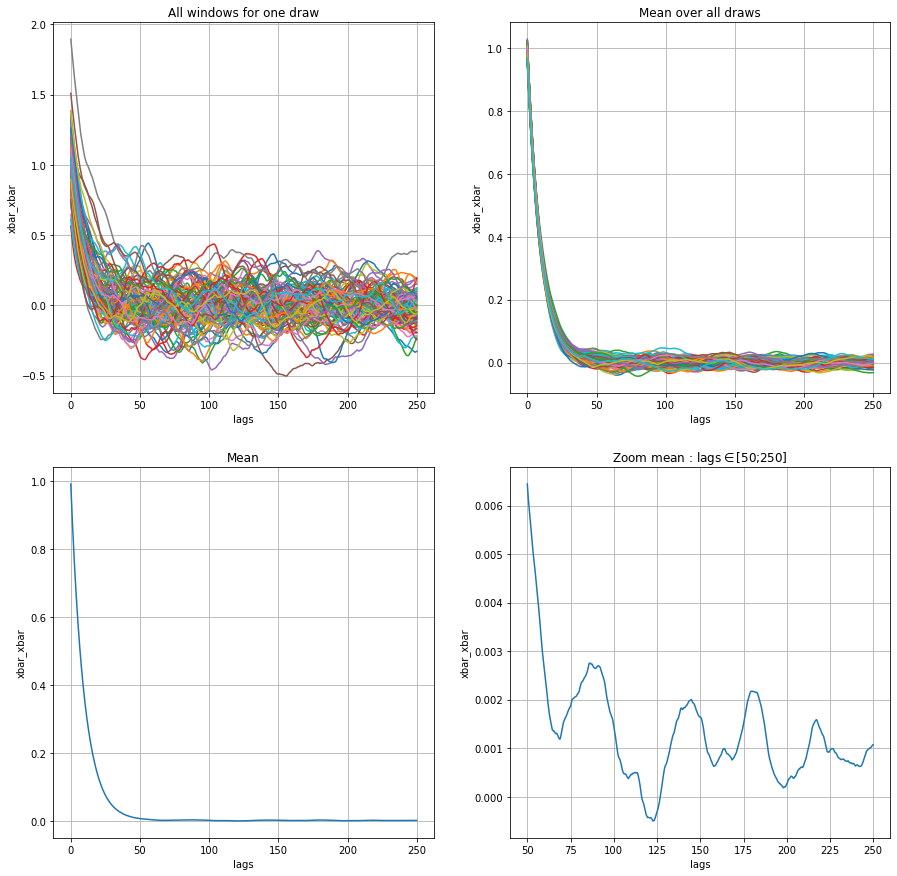

In [14]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xxbar.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xxbar.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xxbar.mean(['draw','windows']).plot(ax=ax[1,0])
xxbar.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid();ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

### Total signal : 

In [16]:
xtotal = xbar + ztilde

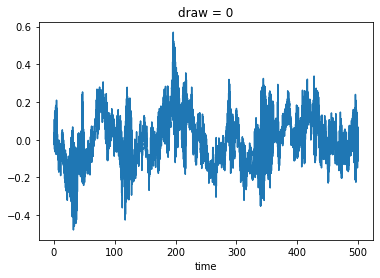

In [17]:
xtotal.sel(draw=0).mean('windows').plot()

In [19]:
xtotal.name = 'xtotal'
xx = ts.correlate(xtotal,xtotal,detrend=False).persist()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Zoom mean : lags$\\in$[50;250]')

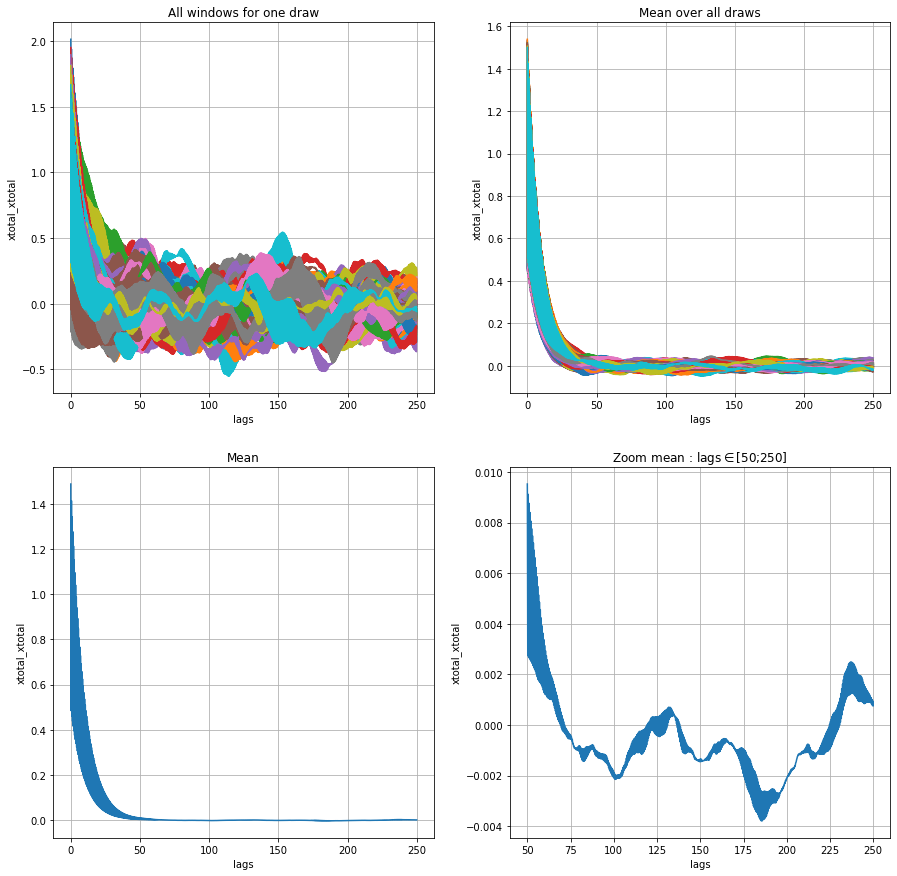

In [22]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xx.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xx.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xx.mean(['draw','windows']).plot(ax=ax[1,0])
xx.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid();ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

## Filter

## Hilbert transform

In [5]:
#fast comp
zhtilde = xr.apply_ufunc(hilbert, ztilde, dask='parallelized', output_dtypes=[complex]).rename('zhtilde')

Rtilde = np.abs(zhtilde)
thetatilde = np.angle(zhtilde)

In [6]:
xxh = ts.correlate(np.imag(zhtilde),np.imag(zhtilde),detrend=False).persist()

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xxh.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xxh.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xxh.mean(['draw','windows']).plot(ax=ax[1,0])
#xxh.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
fig.delaxes(axes[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid()#;ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
#ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

## Autocorrelation

## Spectra